# Creating Naive Bayes Models for Sentiment Analysis using Valheim Twitter Dataset

From the previous project (Sentiment Analysis of Valheim (Video Game) based on Twitter Dataset using Keras BiLSTM), I will reuse the same dataset and create 3 sentiment analysis models using Naive Bayes algorithm. The models are Multinomial Naive Bayes, Complement Naive Bayes, and Bernoulli Naive Bayes. The models will be evaluated twice, first when they're fitted only once with 70:30 split, and second when they're fitted 10 times using k-fold cross validation.

## Preprocessing

In [6]:
import pandas as pd
import numpy as np
import contractions
import matplotlib.pyplot as plt
from collections import Counter
import preprocessor as p
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import cross_validate
import joblib

In [2]:
df = pd.read_csv('scrapped_tweet.csv')
df = df.iloc[:,1:]
df.head()

,User,Date Created,Number of Likes,Source of Tweet,Tweet
0,ElPibeCombo,2022-12-15,0,Twitter Web App,"@BS_artsss Oh, this is so good, i love it! can..."
1,MrsTadertaut,2022-12-15,5,Twitter Web App,Hello lovelies!\n\nTonight we are jumping back...
2,Meganoip,2022-12-15,0,Twitter Web App,Storyline: Noi found Block fighting with giant...
3,TaesTeahouse,2022-12-15,2,Twitter Web App,Ayo I'm totally not biased or anything but yal...
4,John90192410,2022-12-15,1,Twitter for Android,The Queen Wants it all... \nDid Mistlands solo...


In [3]:
tweet = (df["Tweet"].values.tolist())
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
contractions.add('cant', 'can not')

In [4]:
def cleanTweet(arr):
    #Create a new list to store the cleaned tweets
    clean_tweet = []
    for i in range(0,len(arr)):
        #Undercase all letters
        temp = p.clean(arr[i]).casefold()
        #Remove all punctuations
        temp = temp.translate(str.maketrans('', '', string.punctuation))
        #Create new list to store filtered tokenized words
        filtered = []
        #Create new variable for tokenized sentence
        words_temp = word_tokenize(temp)
        #Create new variable to store string that has its contractions removed
        str_temp_fixed = ""
        #Clean the words from contractions
        for j in words_temp:
            j = contractions.fix(j)
            str_temp_fixed += " " + j
        #Create new variable for the cleaned tokenized sentence
        words_temp_fixed = word_tokenize(str_temp_fixed)
        for c in words_temp_fixed:
            #Check if a word is a stop word
            if c not in stop_words:
                #Lemmatize the word, then stores it into the "filtered" list
                c = wordnet_lemmatizer.lemmatize(c)
                filtered.append(c)
        #Create a new variable to store the filtered words that are re-combined back into a sentence
        cleaned = " ".join(filtered)
        #Insert the "cleaned" variable to "clean_tweet" list
        clean_tweet.append(cleaned)
        
    return clean_tweet
    
cleaned = pd.DataFrame(cleanTweet(tweet), columns=["Tweet"])
cleaned.head()

,Tweet
0,oh good love wait get home play valheim
1,hello loveliestonight jumping back made copper...
2,storyline noi found block fighting giant valhe...
3,ayo totally biased anything go watch lil si pl...
4,queen want mistlands solo cheating died time b...


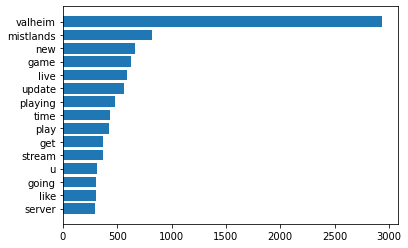

In [7]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

#Take 20 top words
a =  ' '.join(map(str, cleaned["Tweet"]))
counted = {k: v for k, v in sorted(word_count(a).items(), key=lambda item: item[1], reverse=True)}
counted = dict(Counter(counted).most_common(15))

plt.barh(range(len(counted)), list(counted.values()), align='center')
plt.yticks(range(len(counted)), list(counted.keys()))
plt.gca().invert_yaxis()
plt.show()

In [8]:
manual_stop = ['valheim', 'mistlands', 'new', 'game', 'live', 
               'update', 'playing', 'time', 'play', 'get', 'stream', 
               'u', 'going', 'server', 'am', 'pm', 'est', 'tonight', 'today', 'tomorrow', 'yesterday']

#Create a new list to store the cleaned tweets
def manual_tweetClean(arr):
    manual_clean_tweet = []
    for i in range(0,len(tweet)):
        temp = arr.iloc[i]
        #Create new list to store filtered tokenized words
        filtered = []
        #Create new variable for tokenized sentence
        words_temp = word_tokenize(temp)
        for c in words_temp:
            #Check if a word is a stop word
            if c not in manual_stop:
                #Stores it into the "filtered" list
                filtered.append(c)
        #Create a new variable to store the filtered words that are re-combined back into a sentence
        cleaned = " ".join(filtered)
        #Insert the "cleaned" variable to "manual_clean_tweet" list
        manual_clean_tweet.append(cleaned)
    return manual_clean_tweet

#Create a new dataframe filled with the cleaned tweets
cleaned["Tweet"] = manual_tweetClean(cleaned["Tweet"])
cleaned.head()

,Tweet
0,oh good love wait home
1,hello loveliestonight jumping back made copper...
2,storyline noi found block fighting giant drago...
3,ayo totally biased anything go watch lil si
4,queen want solo cheating died biome felt impos...


In [9]:
#Add new columns to the dataframe for the result of the analyzer

sentiments = SentimentIntensityAnalyzer()
cleaned["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in cleaned["Tweet"]]
cleaned["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in cleaned["Tweet"]]
cleaned['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in cleaned["Tweet"]]

cleaned.head()

,Tweet,Positive,Neutral,Compound
0,oh good love wait home,0.703,0.297,0.7964
1,hello loveliestonight jumping back made copper...,0.000,1.000,0.0000
2,storyline noi found block fighting giant drago...,0.000,0.772,-0.7717
3,ayo totally biased anything go watch lil si,0.000,0.745,-0.3384
4,queen want solo cheating died biome felt impos...,0.188,0.348,-0.8360


In [10]:
#Create a new column in the dataframe to store the sentiment of each tweets using Compound value

score = cleaned["Compound"].values
sentiment = []
for i in score:
    if i > 0 :
        sentiment.append(1)
    else:
        sentiment.append(0)
cleaned["Sentiment"] = sentiment

cleaned.head()

,Tweet,Positive,Neutral,Compound,Sentiment
0,oh good love wait home,0.703,0.297,0.7964,1
1,hello loveliestonight jumping back made copper...,0.000,1.000,0.0000,0
2,storyline noi found block fighting giant drago...,0.000,0.772,-0.7717,0
3,ayo totally biased anything go watch lil si,0.000,0.745,-0.3384,0
4,queen want solo cheating died biome felt impos...,0.188,0.348,-0.8360,0


In [11]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(ngram_range=(1,1), tokenizer=token.tokenize)
textcount = cv.fit_transform(cleaned["Tweet"])

In [12]:
X = textcount
y = cleaned["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)

## Modeling

In [13]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

BNB = BernoulliNB()
BNB.fit(X_train, y_train)

CNB = ComplementNB()
CNB.fit(X_train, y_train)

ComplementNB()

In [14]:
y_pred = MNB.predict(X_test)
print("Accuracy of Multinomial Naive Bayes: {:.2f}%".format(metrics.accuracy_score(y_pred, y_test)*100))

y_pred = BNB.predict(X_test)
print("Accuracy of Bernoulli Naive Bayes: {:.2f}%".format(metrics.accuracy_score(y_pred, y_test)*100))

y_pred = CNB.predict(X_test)
print("Accuracy of Complement Naive Bayes: {:.2f}%".format(metrics.accuracy_score(y_pred, y_test)*100))

Accuracy of Multinomial Naive Bayes: 80.87%
Accuracy of Bernoulli Naive Bayes: 77.07%
Accuracy of Complement Naive Bayes: 79.67%


From this result, it shows that Multinomial Naive Bayes is the best algorithm with the most accuracy of 80.87%, just slightly above Complement Naive Bayes with 79.67% of accuracy.

In [16]:
MNB = MultinomialNB()
cvMNB = cross_validate(MNB, X, y, cv=10)
print("Accuracy of Multinomial Naive Bayes 10 k-folds: {:.2f}%".format(cvMNB['test_score'].mean()*100))

BNB = BernoulliNB()
cvBNB = cross_validate(BNB, X, y, cv=10)
print("Accuracy of Bernoulli Naive Bayes 10 k-folds: {:.2f}%".format(cvBNB['test_score'].mean()*100))

CNB = ComplementNB()
cvCNB = cross_validate(CNB, X, y, cv=10)
print("Accuracy of Complement Naive Bayes 10 k-folds: {:.2f}%".format(cvCNB['test_score'].mean()*100))

Accuracy of Multinomial Naive Bayes 10 k-folds: 81.02%
Accuracy of Bernoulli Naive Bayes 10 k-folds: 78.68%
Accuracy of Complement Naive Bayes 10 k-folds: 79.98%


After the 10 k-fold cross validation, Multinomial Naive Bayes still is the best algorithm with average accuracy of 81.02%, just slightly above Complement Naive Bayes with average accuracy of 79.98%.